In [1]:
# # CUDAデバッグ設定（torchインポート前に設定）
# import os

# # CUDAデバイスサイド・アサーションを有効化
# os.environ['TORCH_USE_CUDA_DSA'] = '1'

# # CUDA起動ブロッキングを有効化（エラーを即座に検出）
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# # PyTorchのデバッグモードを有効化
# os.environ['TORCH_CUDA_LAUNCH_BLOCKING'] = '1'

# print("CUDAデバッグ環境変数を設定しました:")
# print(f"  - TORCH_USE_CUDA_DSA = {os.environ['TORCH_USE_CUDA_DSA']}")
# print(f"  - CUDA_LAUNCH_BLOCKING = {os.environ['CUDA_LAUNCH_BLOCKING']}")
# print(f"  - TORCH_CUDA_LAUNCH_BLOCKING = {os.environ['TORCH_CUDA_LAUNCH_BLOCKING']}")


In [2]:
# PyTorchメモリ管理の最適化
import os

# メモリの断片化を回避
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# cuDNNのベンチマークモード無効化（メモリ節約）
os.environ['TORCH_CUDNN_BENCHMARK'] = '0'

print("PyTorchメモリ最適化設定を完了しました:")
print(f"  - PYTORCH_CUDA_ALLOC_CONF = {os.environ['PYTORCH_CUDA_ALLOC_CONF']}")
print(f"  - TORCH_CUDNN_BENCHMARK = {os.environ['TORCH_CUDNN_BENCHMARK']}")


PyTorchメモリ最適化設定を完了しました:
  - PYTORCH_CUDA_ALLOC_CONF = expandable_segments:True
  - TORCH_CUDNN_BENCHMARK = 0


In [3]:
%matplotlib inline
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt


import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
import spikeinterface.comparison as sc
import spikeinterface.exporters as sexp
import spikeinterface.curation as scur
import spikeinterface.widgets as sw

from probeinterface import generate_multi_columns_probe

import cellactivityrecodingsimulator as cars
from cellactivityrecodingsimulator.GroundTruthUnitsObject import GTUnitsObject

c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
global_job_kwargs = dict(n_jobs=4, chunk_duration="1s")
si.set_global_job_kwargs(**global_job_kwargs)

import torch
print(torch.cuda.is_available())


True


In [5]:
from cellactivityrecodingsimulator.Settings import default_settings
from cellactivityrecodingsimulator.Settings import Settings
settings = Settings.from_dict(default_settings()).to_dict()

(<matplotlib.collections.PolyCollection at 0x2993f288dd0>,
 <matplotlib.collections.PolyCollection at 0x2993f244810>)

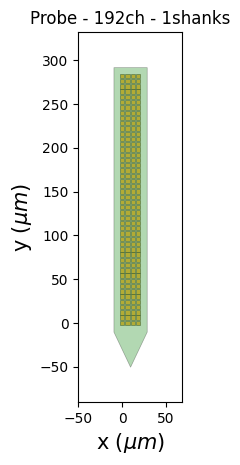

In [6]:
probe = generate_multi_columns_probe(
    num_columns=4,
    num_contact_per_column=48,
    xpitch=6,
    ypitch=6,
    contact_shapes="square",
    contact_shape_params={"width": 5},
        # contact_shape_params : dict, default: {'radius': 6}
        # Parameters for the shape.
        # For circle: {"radius": float}
        # For square: {"width": float}
        # For rectangle: {"width": float, "height": float}
)
device_ids = list(range(probe.get_contact_count()))
probe.set_device_channel_indices(device_ids)
probe.create_auto_shape(margin=10)

probe
from probeinterface.plotting import plot_probe
# fig, ax = plt.subplots()
plot_probe(probe)

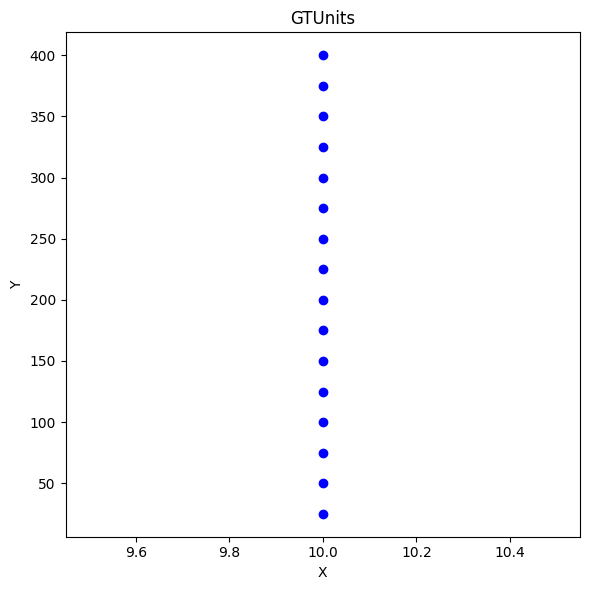

In [7]:

gtunit = GTUnitsObject.generate(
    settings=settings,
    num_column=1, 
    num_unit_per_column=16,
    xpitch=25,
    ypitch=25,
    y_shift_per_column=[25],
    x_shift=10,
    id_major_order="row"
)
gtunit
from cellactivityrecodingsimulator.plot import plot_GTUnits
plot_GTUnits(gtunit)

In [8]:
dir_path = Path("./ex20_condition3/")

In [9]:
# from cellactivityrecodingsimulator.main import run
# carsobj = run(
#     dir=dir_path,
#     settings=settings,
#     units=gtunit,
#     probe=probe
# )
# carsobj
# carsobj.save_npz(dir_path / "cars")

In [10]:
from pathlib import Path
from cellactivityrecodingsimulator.CarsObject import CarsObject
carsobj2 = CarsObject.load_npz(file_path=Path(dir_path / "cars" / "cars.npz"))

CarsObject loaded from ex20_condition3\cars\cars.npz


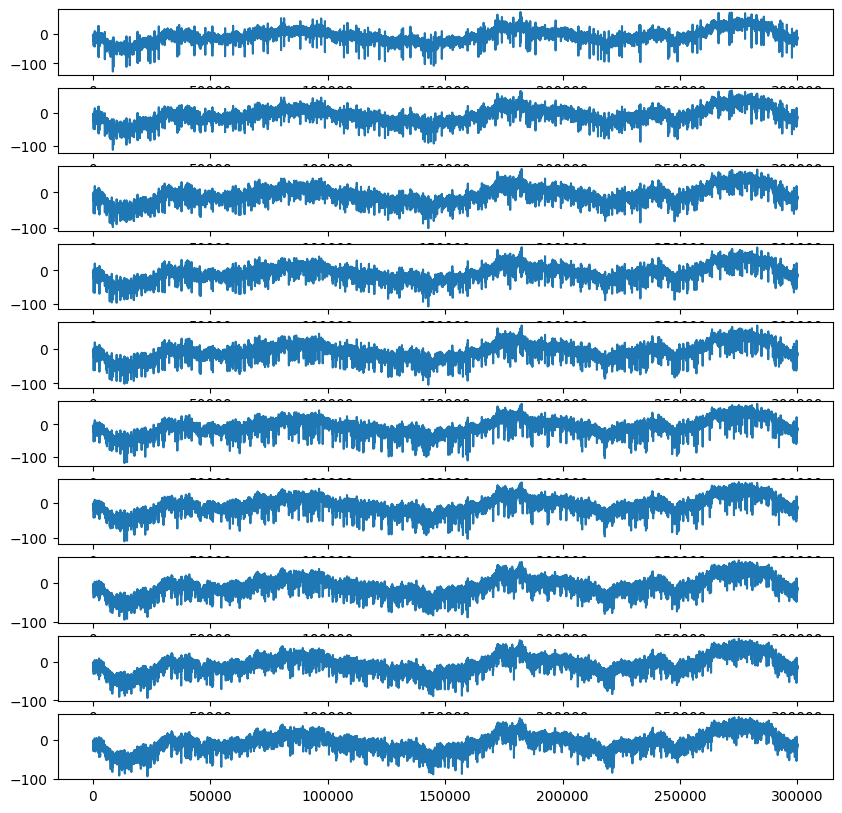

In [11]:
contacts = carsobj2.get_contacts()[0:10]
fig, ax = plt.subplots(10, 1, figsize=(10, 10))
for i, contact in enumerate(contacts):
    ax[i].plot(contact.get_signal("raw"))
plt.show()

In [12]:

recording = carsobj2.get_NumpyRecording([0])
# print(recording.get_probes())
recording = recording.set_probe(probe)
recording


NumpyRecording: 192 channels - 30.0kHz - 1 segments - 300,000 samples - 10.00s - int16 dtype 
                109.86 MiB

In [13]:
print("available sorters", ss.available_sorters())
# mountainsort4/5 はwindows非対応．
print("Installed sorters", ss.installed_sorters())

available sorters ['combinato', 'dartsort', 'hdsort', 'herdingspikes', 'ironclust', 'kilosort', 'kilosort2', 'kilosort2_5', 'kilosort3', 'kilosort4', 'mountainsort4', 'mountainsort5', 'pykilosort', 'rtsort', 'simple', 'spykingcircus', 'spykingcircus2', 'tridesclous', 'tridesclous2', 'waveclus', 'waveclus_snippets', 'yass']
Installed sorters ['dartsort', 'kilosort4', 'simple', 'spykingcircus2', 'tridesclous2']


In [14]:
import psutil
import shutil
import os
import time
from pathlib import Path
from spikeinterface.sorters import run_sorter

def find_and_kill_locker(file_path):
    """
    指定されたファイルをロックしているプロセスを特定し、強制終了する関数。
    psutilライブラリを使用します。
    """
    target_path = Path(file_path).resolve()
    print(f"Searching for process locking: {target_path}")

    # すべての実行中プロセスを反復処理
    for proc in psutil.process_iter(['pid', 'name', 'open_files']):
        try:
            # プロセスが開いているファイルを確認
            if proc.info['open_files']:
                for item in proc.info['open_files']:
                    if Path(item.path).resolve() == target_path:
                        print(f"Found locking process: PID={proc.pid}, Name={proc.name}")
                        # 強制終了
                        proc.kill()
                        print(f"Process PID={proc.pid} has been terminated.")
                        return True
        except (psutil.NoSuchProcess, psutil.AccessDenied, FileNotFoundError):
            continue
    print("No process found locking the file.")
    return False

def save_with_cleanup(recording, folder, overwrite, n_jobs, total_memory):
    """
    ファイルロックエラー発生時に、ロックしているプロセスを終了させてから
    `recording.save()`を再試行するラッパー関数。
    """
    max_retries = 3
    for attempt in range(max_retries):
        try:
            # save()を実行
            return recording.save(folder=folder, overwrite=overwrite, n_jobs=n_jobs, total_memory=total_memory)
        except PermissionError as e:
            if attempt < max_retries - 1:
                print(f"PermissionError caught: {e}. Retrying after cleanup...")
                # ロックしているプロセスを特定して終了を試みる
                if find_and_kill_locker(folder):
                    # プロセス終了後、少し待機して再試行
                    time.sleep(1)
                    continue
                else:
                    # ロッカーが見つからない場合は、手動でディレクトリ削除を試みる
                    try:
                        shutil.rmtree(folder)
                        print("Directory manually removed. Retrying save.")
                        time.sleep(1)
                        continue
                    except PermissionError as manual_e:
                        print(f"Manual removal failed: {manual_e}. The problem persists.")
                        raise manual_e
            else:
                print("Max retries reached. Failing to save.")
                raise e

def run_sorter_with_cleanup(sorter_name, recording, folder, **kwargs):
    """
    SpikeInterfaceのsorterを実行し、PermissionErrorが発生した場合は自己修復を試みる。
    """
    max_retries = 3
    retries = 0

    while retries < max_retries:
        try:
            print(f"Attempting to run sorter: {sorter_name}")
            sorting = run_sorter(sorter_name=sorter_name, recording=recording, folder=folder,
                                 remove_existing_folder=True, **kwargs)
            return sorting
        except PermissionError as e:
            print(f"PermissionError caught: {e}")
            if "The process cannot access the file" in str(e):
                print("File is locked. Attempting to find and kill the locking process.")
                if find_and_kill_locker(folder):
                    print("Locker terminated. Retrying sorter execution.")
                    retries += 1
                    continue
                else:
                    print("Failed to identify and terminate a locking process. Attempting manual removal.")
                    try:
                        shutil.rmtree(folder)
                        print("Directory successfully removed. Retrying sorter execution.")
                        retries += 1
                        continue
                    except PermissionError:
                        print("Manual removal failed. The problem persists.")
                        break
            else:
                raise # Re-raise if it's not the specific file lock error.

    raise RuntimeError("Failed to run sorter after multiple retries due to persistent file lock issues.")

In [15]:
# ==========================================
# ソーター選択
# ==========================================
sorters = ["dartsort", "kilosort4", "spykingcircus2"]
# sorters = ["spykingcircus2"]
# sorters = ["dartsort"]

import pprint
print(f"使用するソーター: {sorters}")

# 各ソーターのパラメータを設定
# ==========================================
# GPU/CPU選択
# ==========================================
# GPUでメモリ不足エラーが発生する場合は "cpu" に変更してください
# CPU実行は遅いですが、メモリエラーを回避できます
USE_DEVICE = "cuda"  # "cuda" または "cpu"
# ==========================================

sort_params_ds = ss.DARTsortSorter.default_params()
sort_params_ks4 = ss.Kilosort4Sorter.default_params()
sort_params_sc2 = ss.Spykingcircus2Sorter.default_params()

# DARTsort用パラメータ（メモリ削減版）
sort_params_ds["device"] = USE_DEVICE
# sort_params_ds["max_waveforms_fit"] = 50  # 10000 → 5000に削減
# sort_params_ds["n_waveforms_fit"] = 50    # 10000 → 5000に削減
# sort_params_ds["gmm_max_spikes"] = 5000   # 1000000 → 500000に削減
# sort_params_ds["chunk_length_samples"] = 500  # チャンクサイズを削減（デフォルト30000）
# sort_params_ds["max_threads_per_worker"] = 1  # スレッド数を制限

# Kilosort4用パラメータ

# Spykingcircus2用パラメータ（必要に応じて調整）

# パラメータ辞書を作成
sort_params_dict = {
    "dartsort": sort_params_ds,
    "kilosort4": sort_params_ks4,
    "spykingcircus2": sort_params_sc2
}

# 選択されたソーターのパラメータを表示
print("\n" + "="*20 + " ソーターパラメータ " + "="*20)
for sorter in sorters:
    print(f"\n{'='*5} {sorter} {'='*5}")
    pprint.pprint(sort_params_dict[sorter])

使用するソーター: ['dartsort', 'kilosort4', 'spykingcircus2']

==================== ソーターパラメータ ====================

===== dartsort =====
{'alignment_ms': 1.0,
 'amplitude_scaling_limit': 1.0,
 'amplitude_scaling_stddev': 0.1,
 'channels_strategy': 'count',
 'chunk_duration': '1s',
 'chunk_length_samples': 30000,
 'core_radius': 35.0,
 'correlation_threshold': 0.1,
 'cov_kind': 'factorizednoise',
 'criterion': 'heldout_elbo',
 'criterion_threshold': 0.0,
 'deduplication_radius_um': 100.0,
 'denoiser_badness_factor': 0.1,
 'density_bandwidth': 5.0,
 'device': 'cuda',
 'do_motion_estimation': True,
 'do_tpca_denoise': True,
 'dredge_only': False,
 'executor': 'threading_unless_multigpu',
 'extrapolation_method': 'kernel',
 'feature_ms_after': 1.25,
 'feature_ms_before': 0.75,
 'featurization_radius_um': 100.0,
 'first_denoiser_thinning': 0.5,
 'fit_radius_um': 75.0,
 'glasso_alpha': None,
 'gmm_max_spikes': 4000000,
 'gmm_merge_decision_algorithm': 'brute',
 'gmm_split_decision_algorithm': 'brute

In [ ]:
# ==========================================
# GPUメモリのクリア
# ==========================================
import torch
import gc

print("実行前のGPUメモリ状態:")
if torch.cuda.is_available():
    print(f"  割り当て済み: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
    print(f"  予約済み: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")
    
    # GPUキャッシュをクリア
    torch.cuda.empty_cache()
    gc.collect()
    
    print("\nクリア後のGPUメモリ状態:")
    print(f"  割り当て済み: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
    print(f"  予約済み: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")
else:
    print("  CUDAが利用できません")


実行前のGPUメモリ状態:
  割り当て済み: 0.00 GB
  予約済み: 0.00 GB

クリア後のGPUメモリ状態:
  割り当て済み: 0.00 GB
  予約済み: 0.00 GB


In [17]:
# preprocess and run sort and make analyzer
import torch
import gc

sorting_list = []
analyzer_list = []
for sorter in sorters:
    print("="*5, sorter, "="*5)
    try:
        if sorter == "kilosort4":
            
            pp_rec = spre.bandpass_filter(recording, freq_min=300, freq_max=3000)
            pp_rec = spre.common_reference(pp_rec, reference="global")
            pp_rec = spre.whiten(pp_rec, int_scale=200)
            pp_rec = spre.correct_motion(pp_rec, preset="kilosort_like")
            pp_rec = pp_rec.save(folder=f"{dir_path}/{sorter}/pp_rec",overwrite=True, n_jobs=8, total_memory="2G")
            # pp_rec = save_with_cleanup(pp_rec, folder=f"preprocessed_data_for_{sorter}_{example_name}_{condition}", overwrite=True, n_jobs=8, total_memory="2G")
            recording_preprocessed = pp_rec
        else:
            recording_f = spre.bandpass_filter(recording, freq_min=300, freq_max=3000)
            recording_cmr = spre.common_reference(recording_f, reference="global", operator="median")
            recording_preprocessed = recording_cmr.save(format="binary", folder=f"{dir_path}/{sorter}/pp_rec", overwrite=True)
        
        sorting = ss.run_sorter(sorter_name=sorter, folder=f"{dir_path}/{sorter}/sorting" , remove_existing_folder=True, recording=recording_preprocessed, **sort_params_dict[sorter])
        # sorting = run_sorter_with_cleanup(sorter_name=sorter, folder=f"{dir_path}/{sorter}/sorting" , remove_existing_folder=True, recording=recording_preprocessed, **sort_params_dict[sorter])
        print(sorting)
        sorting_list.append(sorting)

        analyzer = si.create_sorting_analyzer(sorting=sorting, recording=recording_preprocessed, format='binary_folder', folder=f'{dir_path}/{sorter}/analyzer', overwrite=True)
        print(analyzer)
        analyzer_list.append(analyzer)
    except Exception as e:
        print(f"Error occurred: {e}")
        sorting_list.append(None)
        analyzer_list.append(None)
        
        # エラー時もメモリをクリア
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            gc.collect()
        continue
    finally:
        # 使用済み変数を削除
        if 'pp_rec' in locals():
            del pp_rec
        if 'recording_preprocessed' in locals():
            del recording_preprocessed
        
        # 各ソーター実行後にGPUメモリをクリア
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            gc.collect()
            print(f"  GPUメモリクリア完了 - 割り当て済み: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")

===== dartsort =====
write_binary_recording 
engine=process - n_jobs=4 - samples_per_chunk=30,000 - chunk_memory=10.99 MiB - total_memory=43.95 MiB - chunk_duration=1.00s


  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\tornado\platform\asyncio.py", line 211, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\tanaka-users\AppData\Roaming\uv\python\cpython-3.11.13-windows-x86_64-none\Lib\asyncio\base_events.py", line 608, in run_forever
    self._run_once()
  File "C:\Users\tanaka-users\AppData\Roaming\u

keep_ids: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
        90, 91, 92, 93]), shape: torch.Size([94]), dtype: torch.int64
ids: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93], shape: (94,), dtype: int64


Likelihoods: 100%|██████████| 26/26 [00:00<00:00, 27.08unit/s]


keep_ids: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25]), shape: torch.Size([26]), dtype: torch.int64
ids: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25], shape: (26,), dtype: int64


Load examples for feature fitting [spk/1s=781.0]: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]
Localizer converged at epoch=10 [loss=0.0003,val=0.0003]:  10%|█         | 10/100 [00:09<01:27,  1.02epoch/s]
TemplateMatching 1.0s/it [spk/it=%%%]:   0%|          | 0/10 [00:00<?, ?it/s]  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\tornado\platfo

keep_ids: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), shape: torch.Size([11]), dtype: torch.int64
ids: [ 0  1  2  3  4  5  6  7  8  9 10], shape: (11,), dtype: int64


Likelihoods: 100%|██████████| 11/11 [00:00<?, ?unit/s]


keep_ids: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), shape: torch.Size([11]), dtype: torch.int64
ids: [ 0  1  2  3  4  5  6  7  8  9 10], shape: (11,), dtype: int64


Likelihoods: 100%|██████████| 11/11 [00:00<?, ?unit/s]


keep_ids: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), shape: torch.Size([11]), dtype: torch.int64
ids: [ 0  1  2  3  4  5  6  7  8  9 10], shape: (11,), dtype: int64


Likelihoods: 100%|██████████| 11/11 [00:00<?, ?unit/s]


keep_ids: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), shape: torch.Size([11]), dtype: torch.int64
ids: [ 0  1  2  3  4  5  6  7  8  9 10], shape: (11,), dtype: int64


Likelihoods: 100%|██████████| 11/11 [00:00<00:00, 1277.44unit/s]


keep_ids: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), shape: torch.Size([11]), dtype: torch.int64
ids: [ 0  1  2  3  4  5  6  7  8  9 10], shape: (11,), dtype: int64


Likelihoods: 100%|██████████| 11/11 [00:00<00:00, 2196.91unit/s]


keep_ids: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), shape: torch.Size([11]), dtype: torch.int64
ids: [ 0  1  2  3  4  5  6  7  8  9 10], shape: (11,), dtype: int64


Likelihoods: 100%|██████████| 11/11 [00:00<00:00, 1885.31unit/s]


Getting result from folder: c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\ex20_condition3\dartsort\sorting\sorter_output
NumpySorting: 1 units - 1 segments - 30.0kHz


estimate_sparsity (workers: 4 processes): 100%|██████████| 10/10 [00:01<00:00,  9.39it/s]


create_sorting_analyzer: recording does not have scaling to uV, forcing return_in_uV=False


  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\tornado\platform\asyncio.py", line 211, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\tanaka-users\AppData\Roaming\uv\python\cpython-3.11.13-windows-x86_64-none\Lib\asyncio\base_events.py", line 608, in run_forever
    self._run_once()
  File "C:\Users\tanaka-users\AppData\Roaming\u

SortingAnalyzer: 192 channels - 1 units - 1 segments - binary_folder - sparse - has recording
Loaded 0 extensions
  GPUメモリクリア完了 - 割り当て済み: 0.36 GB
===== kilosort4 =====


detect and localize (workers: 4 processes): 100%|██████████| 10/10 [00:00<00:00, 15.44it/s]
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\tornado\platform\asyncio.py", line 211, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\tanaka-users\AppData\Roaming\uv\python\cpython-3.11.13-windows-x86_64-none\Lib\asyncio\base_events.py", l

write_binary_recording 
engine=process - n_jobs=4 - samples_per_chunk=651,041 - chunk_memory=476.84 MiB - total_memory=1.86 GiB - chunk_duration=21.70s


100%|██████████| 1/1 [00:00<00:00, 15.98it/s]


KiloSortSortingExtractor: 22 units - 1 segments - 30.0kHz


estimate_sparsity (workers: 4 processes): 100%|██████████| 10/10 [00:00<00:00, 17.56it/s]
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\tornado\platform\asyncio.py", line 211, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\tanaka-users\AppData\Roaming\uv\python\cpython-3.11.13-windows-x86_64-none\Lib\asyncio\base_events.py", lin

SortingAnalyzer: 192 channels - 22 units - 1 segments - binary_folder - sparse - has recording
Loaded 0 extensions
  GPUメモリクリア完了 - 割り当て済み: 0.36 GB
===== spykingcircus2 =====
write_binary_recording 
engine=process - n_jobs=4 - samples_per_chunk=30,000 - chunk_memory=10.99 MiB - total_memory=43.95 MiB - chunk_duration=1.00s


  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\tornado\platform\asyncio.py", line 211, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\tanaka-users\AppData\Roaming\uv\python\cpython-3.11.13-windows-x86_64-none\Lib\asyncio\base_events.py", line 608, in run_forever
    self._run_once()
  File "C:\Users\tanaka-users\AppData\Roaming\u

NumpyFolder (NumpyFolderSorting): 107 units - 1 segments - 30.0kHz


estimate_sparsity (workers: 4 processes): 100%|██████████| 10/10 [00:00<00:00, 303.12it/s]
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\tornado\platform\asyncio.py", line 211, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\tanaka-users\AppData\Roaming\uv\python\cpython-3.11.13-windows-x86_64-none\Lib\asyncio\base_events.py", li

create_sorting_analyzer: recording does not have scaling to uV, forcing return_in_uV=False
SortingAnalyzer: 192 channels - 107 units - 1 segments - binary_folder - sparse - has recording
Loaded 0 extensions
  GPUメモリクリア完了 - 割り当て済み: 0.36 GB


In [18]:
extensions_to_compute = [
    "random_spikes",
    "waveforms",
    "noise_levels",
    "templates",
    "spike_amplitudes",
    "unit_locations",
    "spike_locations",
    "correlograms",
    "template_similarity"
]

extension_params = {
    "unit_locations": {"method": "center_of_mass"},
    "spike_locations": {"ms_before": 0.1},
    "correlograms": {"bin_ms": 0.1},
    "template_similarity": {"method": "cosine_similarity"}
}
try:
    if len(analyzer_list) == 0:
        for sorter in sorters:
            try:
                analyzer = si.load_sorting_analyzer(folder=f'{dir_path}/{sorter}/analyzer')
                print("="*5, sorter, "="*5)
                possible_extensions = analyzer.get_computable_extensions()
                print(possible_extensions)
                print(analyzer.has_recording())
            except Exception as e:
                print(f"Error loading analyzer: {e}")
                continue
    else:
        for index, analyzer in enumerate(analyzer_list):
            try:
                print("="*5, sorters[index], "="*5)
                possible_extensions = analyzer.get_computable_extensions()
                print(possible_extensions)
                print(analyzer.has_recording())
                analyzer.compute(extensions_to_compute, extension_params=extension_params)
            except Exception as e:
                print(f"Error loading analyzer: {e}")
                continue
except NameError:
    print("No analyzer list found.")
    analyzer_list = []
    for sorter in sorters:
        try:
            analyzer = si.load_sorting_analyzer(folder=f'{dir_path}/{sorter}/analyzer')
            print("="*5, sorter, "="*5)
            possible_extensions = analyzer.get_computable_extensions()
            print(possible_extensions)
            print(analyzer.has_recording())
        except Exception as e:
            print(f"Error loading analyzer: {e}")
            continue

===== dartsort =====
['random_spikes', 'waveforms', 'templates', 'noise_levels', 'amplitude_scalings', 'correlograms', 'isi_histograms', 'principal_components', 'spike_amplitudes', 'spike_locations', 'template_metrics', 'template_similarity', 'unit_locations', 'quality_metrics']
True


noise_level (workers: 4 processes): 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]
Compute : spike_amplitudes + spike_locations (workers: 4 processes): 100%|██████████| 10/10 [00:00<00:00, 111.47it/s]


===== kilosort4 =====
['random_spikes', 'waveforms', 'templates', 'noise_levels', 'amplitude_scalings', 'correlograms', 'isi_histograms', 'principal_components', 'spike_amplitudes', 'spike_locations', 'template_metrics', 'template_similarity', 'unit_locations', 'quality_metrics']
True


noise_level (workers: 4 processes): 100%|██████████| 20/20 [00:01<00:00, 11.02it/s]
Compute : spike_amplitudes + spike_locations (workers: 4 processes): 100%|██████████| 10/10 [00:00<00:00, 202.67it/s]


===== spykingcircus2 =====
['random_spikes', 'waveforms', 'templates', 'noise_levels', 'amplitude_scalings', 'correlograms', 'isi_histograms', 'principal_components', 'spike_amplitudes', 'spike_locations', 'template_metrics', 'template_similarity', 'unit_locations', 'quality_metrics']
True


noise_level (workers: 4 processes): 100%|██████████| 20/20 [00:01<00:00, 11.21it/s]
Compute : spike_amplitudes + spike_locations (workers: 4 processes): 100%|██████████| 10/10 [00:00<00:00, 275.23it/s]


===== dartsort =====
===== kilosort4 =====
===== spykingcircus2 =====


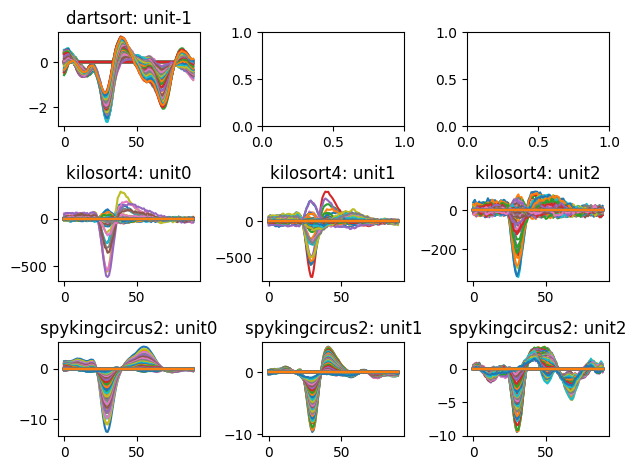

In [19]:
n = len(analyzer_list)
n_unit = 3
fig, ax = plt.subplots(n,n_unit)
for analyzer_index, analyzer in enumerate(analyzer_list):
    try:
        print("="*5, sorters[analyzer_index], "="*5)
        for unit_index, unit_id in enumerate(analyzer.unit_ids[:n_unit]):
            template = analyzer.get_extension("templates").get_data(operator="average")[unit_index]
            ax[analyzer_index,unit_index].plot(template)
            ax[analyzer_index,unit_index].set_title(f"{sorters[analyzer_index]}: unit{unit_id}")
    except Exception as e:
        print(f"Error plotting templates: {e}")
        continue
fig.tight_layout()

In [20]:
comp_gt_list = []
for sorting_index, sorting in enumerate(sorting_list):
    try:
        print("="*5, sorters[sorting_index], "="*5)
        comp_gt = sc.compare_sorter_to_ground_truth(
            gt_sorting=gtunit.to_Sorting(sampling_frequency=30000), 
            tested_sorting=sorting, 
            agreement_method="count",
            )
        comp_gt_list.append(comp_gt)
    except Exception as e:
        print(f"Error comparing sorter to ground truth: {e}")
        continue
# comp_pair = sc.compare_two_sorters(sorting1=sorting_KS4, sorting2=sorting_SC2)
# comp_multi = sc.compare_multiple_sorters(
#     sorting_list=[sorting_TDC, sorting_SC2, sorting_KS2], name_list=["tdc", "sc2", "ks2"]
# )

===== dartsort =====
===== kilosort4 =====
===== spykingcircus2 =====


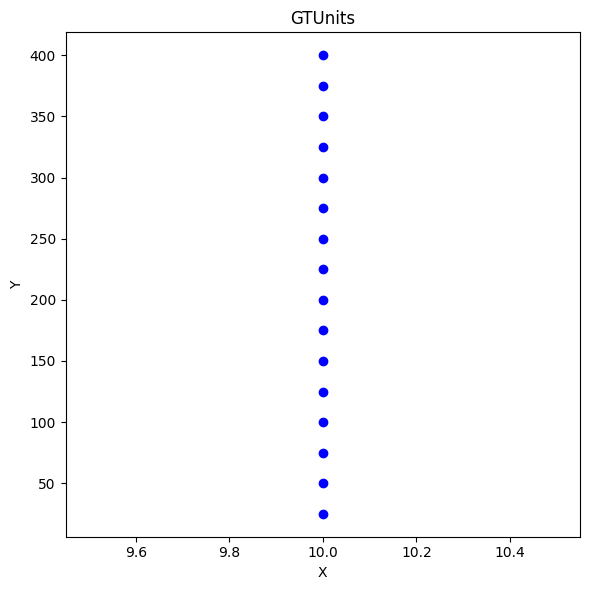

[[ 10  25   0]
 [ 10  50   0]
 [ 10  75   0]
 [ 10 100   0]
 [ 10 125   0]
 [ 10 150   0]
 [ 10 175   0]
 [ 10 200   0]
 [ 10 225   0]
 [ 10 250   0]
 [ 10 275   0]
 [ 10 300   0]
 [ 10 325   0]
 [ 10 350   0]
 [ 10 375   0]
 [ 10 400   0]]


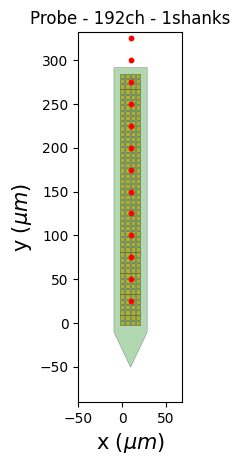

In [21]:
from probeinterface.plotting import plot_probe
from cellactivityrecodingsimulator.plot import plot_GTUnits
plot_GTUnits(gtunit)
gt_unit_positions = carsobj2.get_units_position(as_array=True)
print(gt_unit_positions)
plot_probe(probe)
plt.scatter(gt_unit_positions[:,0], gt_unit_positions[:,1], c="red", s=10)

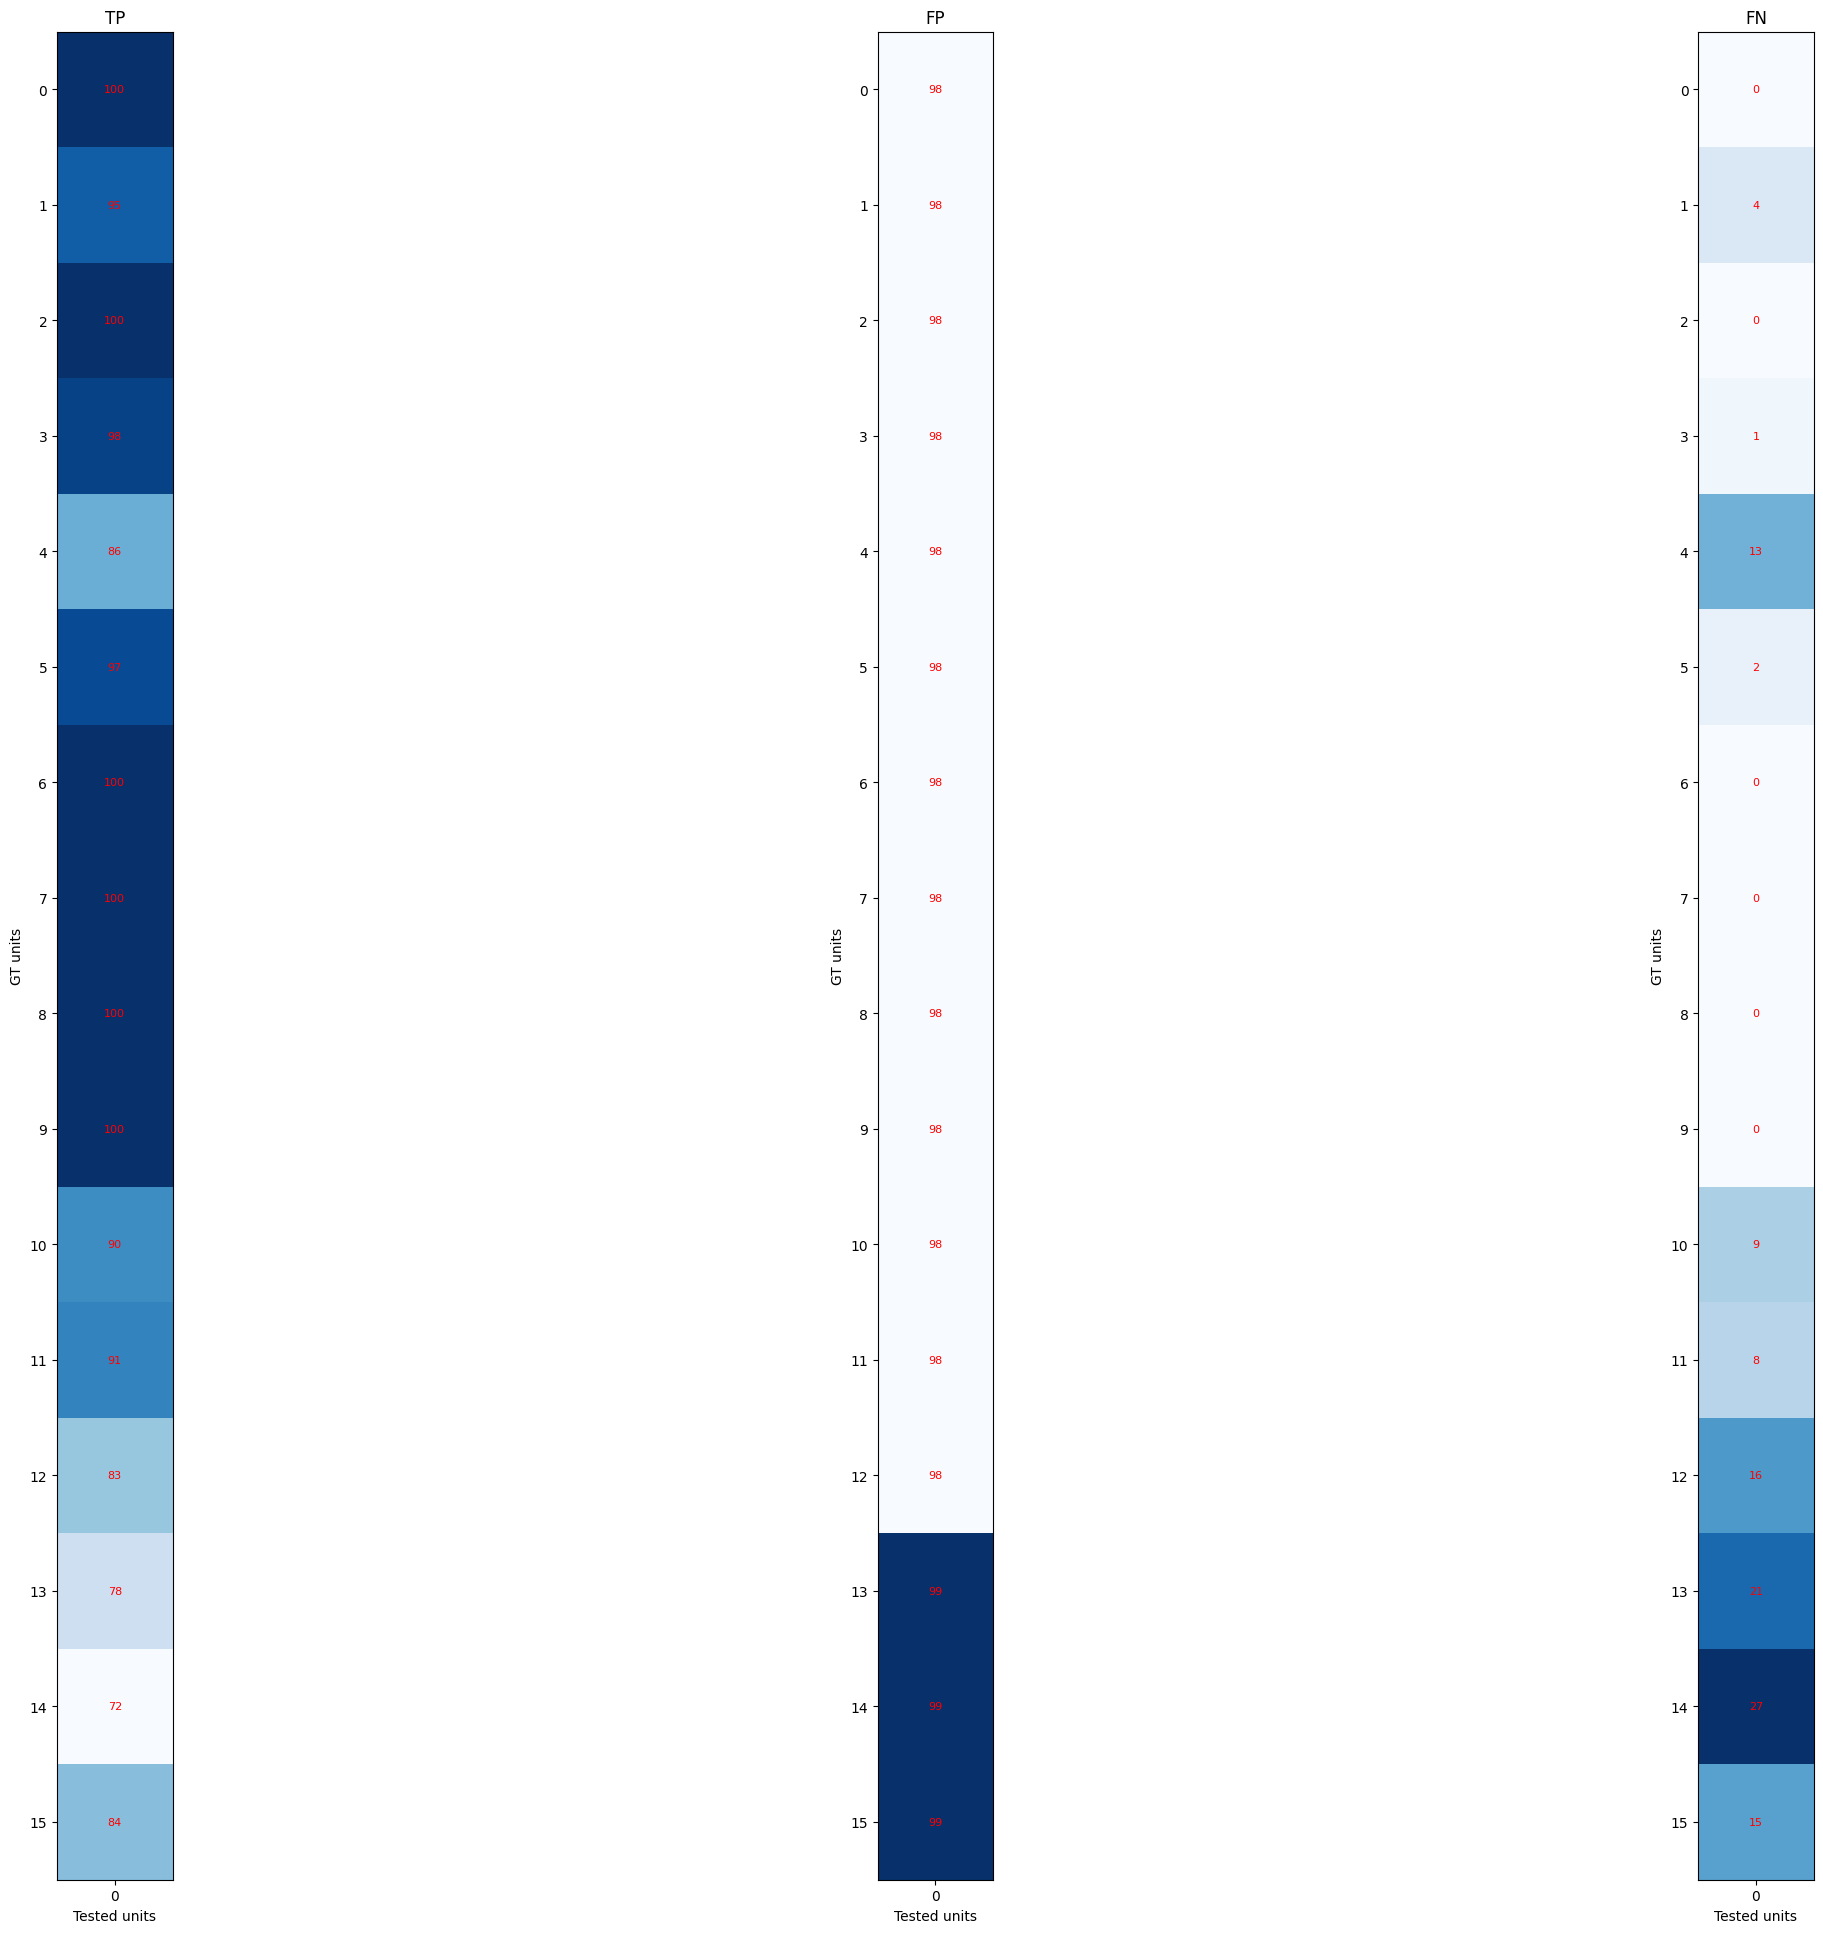

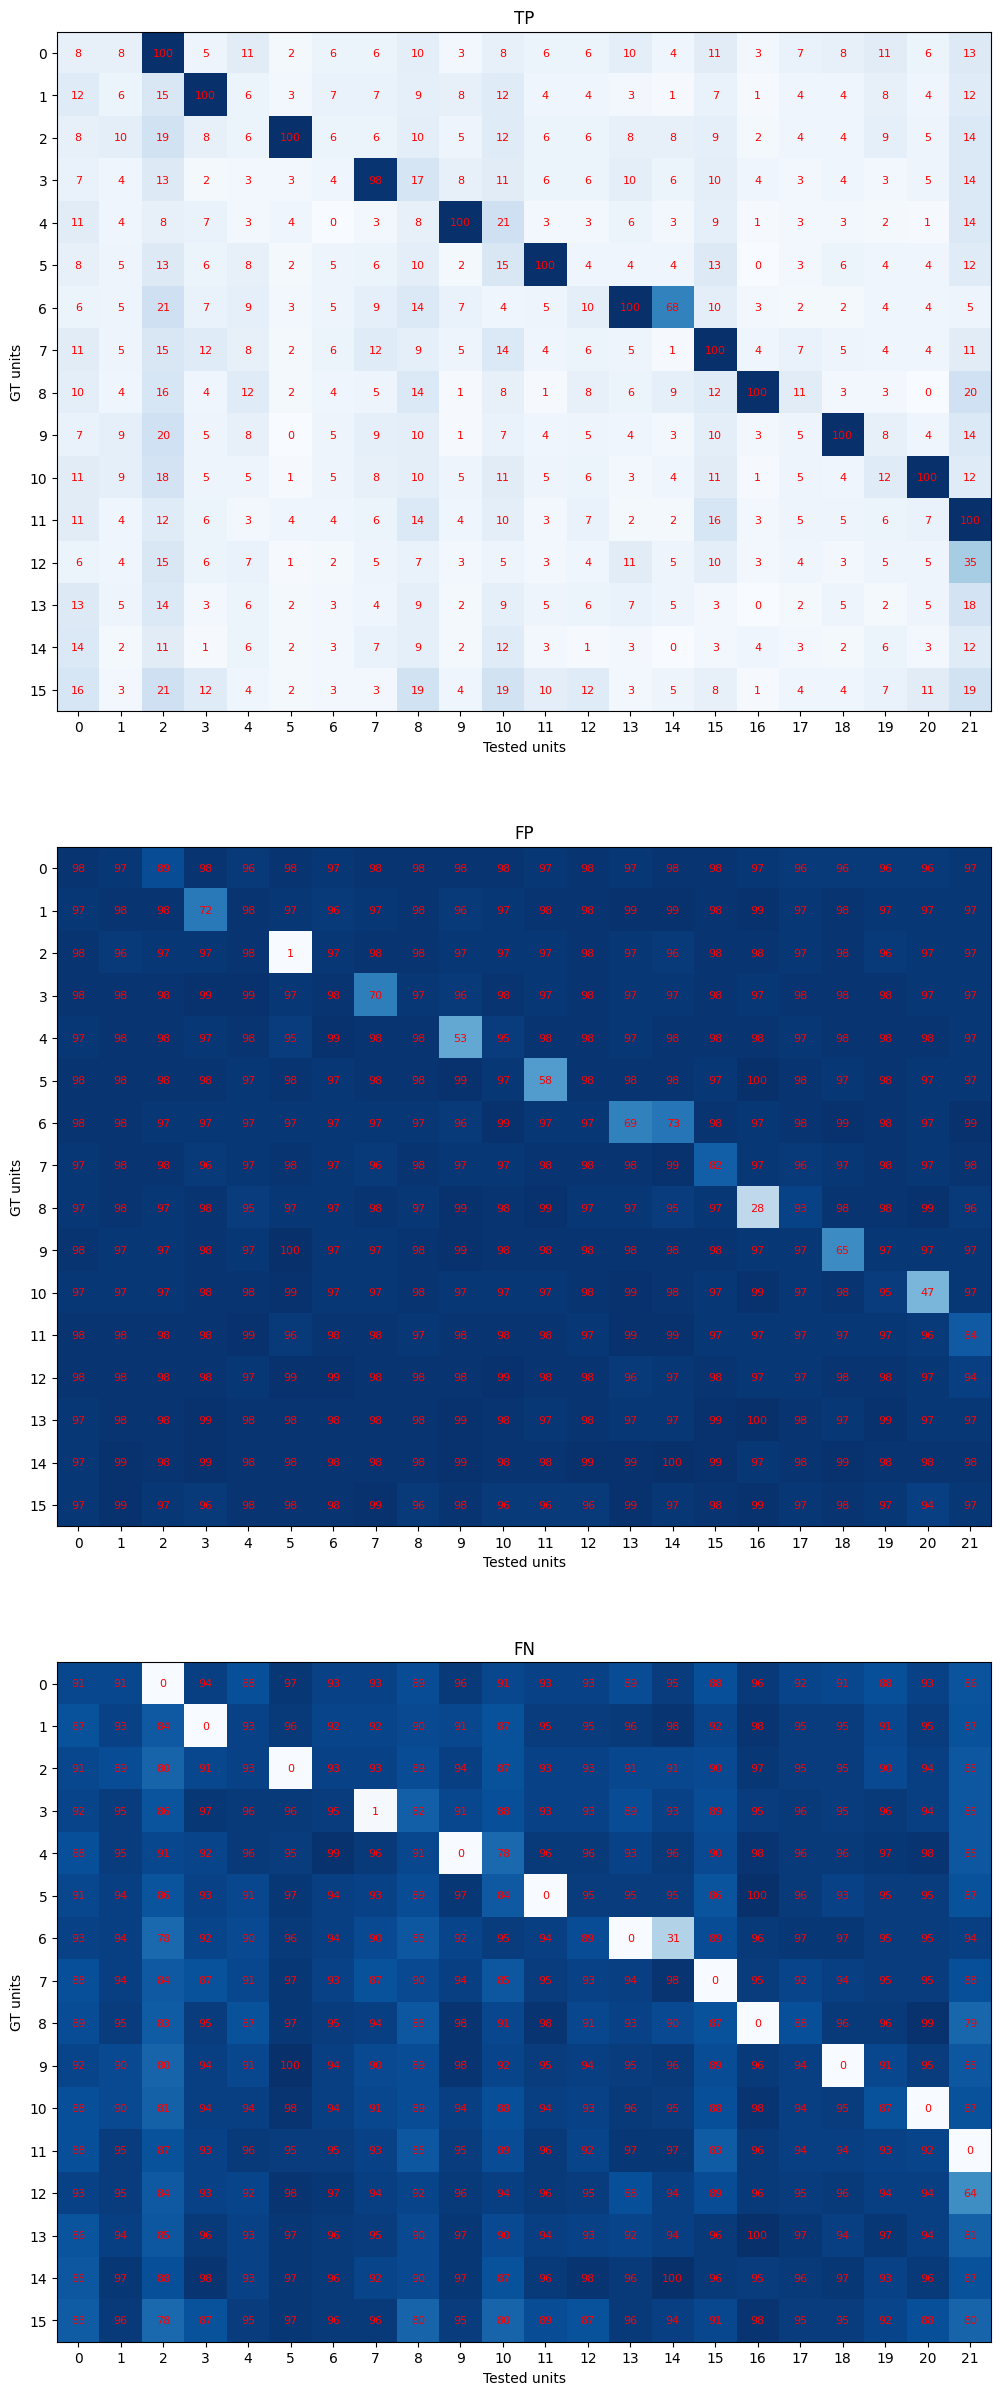

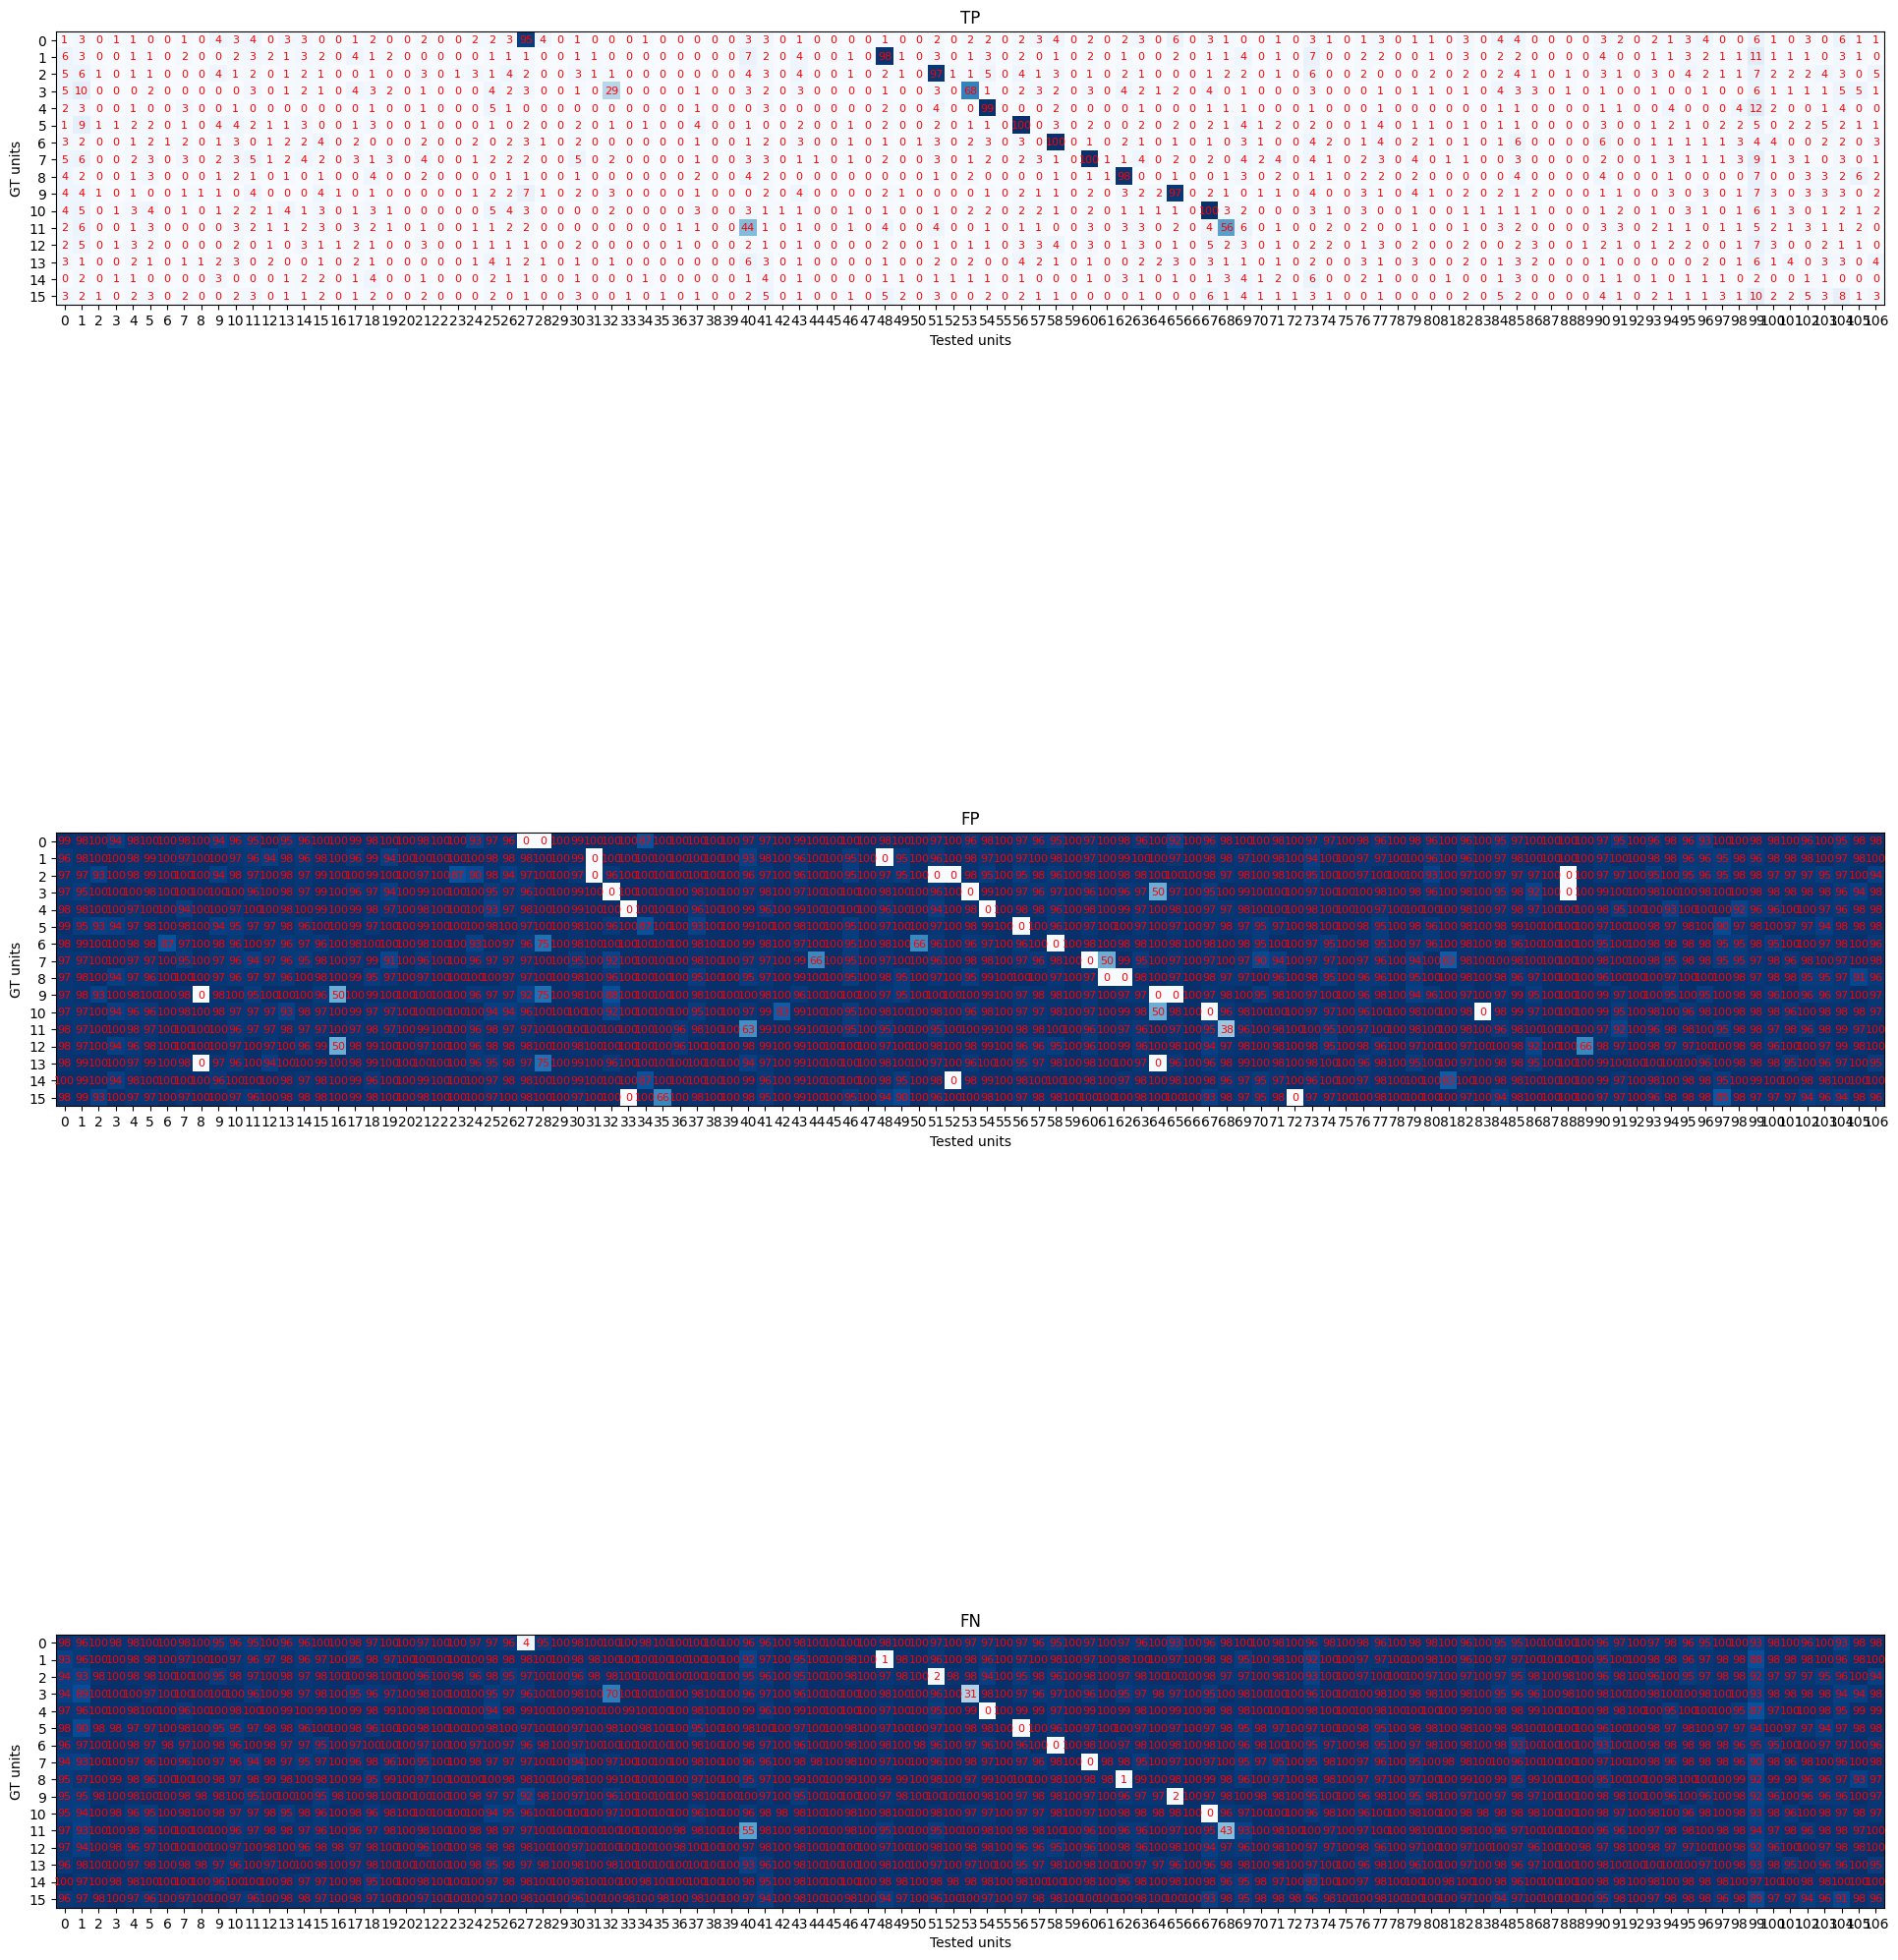

In [22]:
import numpy as np
from typing import List

def compare_spike_times(gt_sorting, tested_sorting, delta_time_ms: float, fs: float, mode: str = "rate") -> np.ndarray:
    """
    Compares two lists of spike times and builds a simple agreement matrix.
    This function allows for one-to-many matching.

    Args:
        gt_sorting: The Ground Truth sorting object.
        tested_sorting: The tested sorting object.
        delta_time_ms (float): The time tolerance for matching, in milliseconds.
        fs (float): The sampling frequency in Hz.
        mode (str): The mode to calculate matrix. "rate" or "count".
    Returns:
        np.ndarray: An agreement matrix where rows correspond to GT units and columns correspond to tested units. The values are the number of matching spikes.
    """
    # Convert delta_time from ms to frames
    delta_time_frames = delta_time_ms * fs / 1000

    gt_unit_ids = gt_sorting.get_unit_ids()
    gt_spike_times = {unit_id: gt_sorting.get_unit_spike_train(unit_id) for unit_id in gt_unit_ids}
    tested_unit_ids = tested_sorting.get_unit_ids()
    tested_spike_times = {unit_id: tested_sorting.get_unit_spike_train(unit_id) for unit_id in tested_unit_ids}
    n_gt = len(gt_unit_ids)
    n_tested = len(tested_unit_ids)
    TP_matrix = np.zeros((n_gt, n_tested), dtype=int)
    FP_matrix = np.zeros((n_gt, n_tested), dtype=int)
    FN_matrix = np.zeros((n_gt, n_tested), dtype=int)

    # Correct iteration: Iterate through the individual spike time arrays
    for i, gt_id in enumerate(gt_unit_ids):
        gt_unit_spikes = gt_spike_times[gt_id]
        if gt_unit_spikes.size == 0:
            continue
        
        for j, tested_id in enumerate(tested_unit_ids):
            tested_unit_spikes = tested_spike_times[tested_id]
            if tested_unit_spikes.size == 0:
                continue

            matches = 0
            
            # The original code had a bug here.
            # It was iterating over a list of arrays, not a single array.
            
            # Correct logic: for each tested spike, find a match in the GT unit's array
            for gt_spike_time in gt_unit_spikes:
                # np.searchsorted must be used on a single, 1D array
                idx = np.searchsorted(tested_unit_spikes, gt_spike_time)
                
                found_match = False
                if idx < len(tested_unit_spikes) and np.abs(tested_unit_spikes[idx] - gt_spike_time) <= delta_time_frames:
                    found_match = True
                elif idx > 0 and np.abs(tested_unit_spikes[idx-1] - gt_spike_time) <= delta_time_frames:
                    found_match = True
                
                if found_match:
                    matches += 1
                    
            TP_matrix[i, j] = matches if mode == "count" else matches / len(gt_unit_spikes) * 100
            FP_matrix[i, j] = len(tested_unit_spikes) - matches if mode == "count" else ((len(tested_unit_spikes) - matches) / len(tested_unit_spikes) * 100)
            FN_matrix[i, j] = len(gt_unit_spikes) - matches if mode == "count" else ((len(gt_unit_spikes) - matches) / len(gt_unit_spikes) * 100)
            
    return TP_matrix, FP_matrix, FN_matrix

def plot_matrix(matrix, title, gt_unit_num, tested_unit_num, ax):
    im = ax.imshow(matrix, cmap="Blues")
    ax.set_title(title)
    ax.set_xlabel("Tested units")
    ax.set_ylabel("GT units")
    ax.set_xticks(range(tested_unit_num))
    ax.set_yticks(range(gt_unit_num))
    
    # 各セルに値を書き込む
    for i in range(gt_unit_num):
        for j in range(tested_unit_num):
            text = ax.text(j, i, f'{matrix[i, j]}',
                         ha="center", va="center", color="red", fontsize=8)

    # Example usage
# You need to specify a sampling frequency (fs) and a jitter threshold (delta_time_ms)
sampling_frequency = 30000.0  # Hz
time_threshold_ms = 1.0      # milliseconds
gt_sorting = gtunit.to_Sorting(sampling_frequency=30000)
matrixes = {}
# Calculate the agreement matrix
for i, sorting in enumerate(sorting_list):
    if sorting is not None:
        TP_matrix, FP_matrix, FN_matrix = compare_spike_times(
            gt_sorting=gt_sorting,
            tested_sorting=sorting,
            delta_time_ms=time_threshold_ms,
            fs=sampling_frequency,
            mode="rate"
        )

        if len(gt_sorting.get_unit_ids()) > len(sorting_list[i].get_unit_ids()):
            fig, ax = plt.subplots(1, 3, figsize=(30,24))
        else:
            fig, ax = plt.subplots(3, 1, figsize=(24,30))
        plot_matrix(TP_matrix, "TP", len(gt_sorting.get_unit_ids()), len(sorting_list[i].get_unit_ids()), ax[0])
        plot_matrix(FP_matrix, "FP", len(gt_sorting.get_unit_ids()), len(sorting_list[i].get_unit_ids()), ax[1])
        plot_matrix(FN_matrix, "FN", len(gt_sorting.get_unit_ids()), len(sorting_list[i].get_unit_ids()), ax[2])
        # fig.tight_layout()
        matrixes[sorters[i]] = {
            "TP": TP_matrix,
            "FP": FP_matrix,
            "FN": FN_matrix
        }
    else:
        continue


===== dartsort =====
single: []
multi: [-1]
===== kilosort4 =====
single: []
multi: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
===== spykingcircus2 =====
single: [2, 3, 4, 5, 7, 8, 10, 12, 13, 14, 15, 16, 17, 18, 20, 29, 31, 32, 35, 39, 40, 46, 48, 51, 52, 53, 54, 56, 61, 65, 69, 72, 79, 81, 82, 86, 89, 98, 99, 100, 101, 102, 103, 104, 105, 106, 108, 109, 113, 117, 119, 121, 124, 125, 126, 129, 133, 134, 135, 137, 138, 139, 142, 143, 145, 146, 147, 151, 153, 154, 155, 156, 157, 158, 159, 163, 168, 169, 173, 174, 176, 178, 179, 180, 181, 183, 184, 186, 188, 189, 190, 192, 193, 194, 195, 196, 197, 198]
multi: [0, 1, 11, 95, 96, 144, 150, 172, 191]


  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\tornado\platform\asyncio.py", line 211, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\tanaka-users\AppData\Roaming\uv\python\cpython-3.11.13-windows-x86_64-none\Lib\asyncio\base_events.py", line 608, in run_forever
    self._run_once()
  File "C:\Users\tanaka-users\AppData\Roaming\u

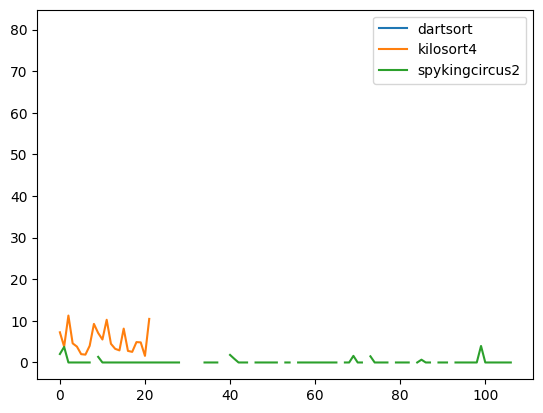

In [23]:
def get_isi(spike_times):
    isi = np.diff(spike_times)
    return isi

def get_isi_violation_rate(spike_times, threshold_ms=2.0, sampling_frequency=30000.0):
    isi = get_isi(spike_times)
    isi_violation = np.sum(isi < threshold_ms * sampling_frequency / 1000) / len(isi) * 100
    return isi_violation

def get_isi_violation_rate_by_unit(sorting, threshold_ms=2.0, sampling_frequency=30000.0, dtype="dict"):
    isi_violation = {}
    for unit_id in sorting.get_unit_ids():
        isi_violation[unit_id] = get_isi_violation_rate(sorting.get_unit_spike_train(unit_id), threshold_ms, sampling_frequency)
    if dtype == "dict":
        return isi_violation
    elif dtype == "list":
        return list(isi_violation.values())
    else:
        ValueError("dtype must be 'dict' or 'list'")

def get_single_multi_unit(sorting, threshold_rate=50, threshold_ms=2.0, sampling_frequency=30000.0, unit_type="both"):
    single_unit = []
    multi_unit = []
    isi_violation = get_isi_violation_rate_by_unit(sorting, threshold_ms, sampling_frequency)
    unit_ids = sorting.get_unit_ids()
    for i, unit_id in enumerate(unit_ids):
        if isi_violation[unit_id] > threshold_rate:
            multi_unit.append(int(unit_id))
        else:
            single_unit.append(int(unit_id))

    try:    
        if unit_type == "single":
            return single_unit
        elif unit_type == "multi":
            return multi_unit
        elif unit_type == "both":
            return single_unit, multi_unit
    except:
        ValueError("unit_type must be 'single', 'multi', or 'both'")
    
        

sampling_frequency = 30000.0  # Hz
time_threshold_ms = 1.0      # milliseconds
mua_threshold_rate = 0.2
for i, sorting in enumerate(sorting_list):
    if sorting is not None:
        isi_violation_dict = get_isi_violation_rate_by_unit(sorting)
        isi_violation_values = list(isi_violation_dict.values())
        plt.plot(isi_violation_values, label=sorters[i])
        single_unit, multi_unit = get_single_multi_unit(sorting, threshold_rate=mua_threshold_rate, unit_type="both")
        print("="*5, f"{sorters[i]}", "="*5)
        print(f"single: {single_unit}")
        print(f"multi: {multi_unit}")
    else:
        continue
plt.legend()


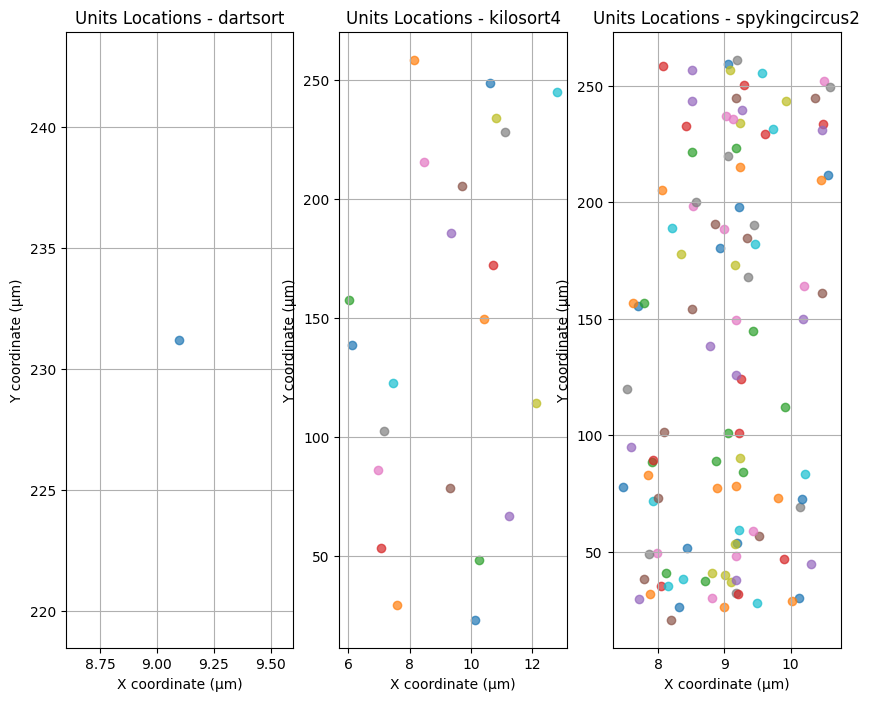

In [24]:
fig, ax = plt.subplots(1, len(analyzer_list), figsize=(10, 8))
for index, analyzer in enumerate(analyzer_list):
    if analyzer is not None:
        unit_locations = analyzer.get_extension("unit_locations").get_data()
        [ax[index].scatter(unit_location[0], unit_location[1], alpha=0.7) for unit_location in unit_locations]
        ax[index].set_title(f"Units Locations - {sorters[index]}")
        ax[index].set_xlabel("X coordinate (μm)")
        ax[index].set_ylabel("Y coordinate (μm)")
        ax[index].grid(True)
    else:
        continue
plt.show()
    

(1, 90, 192)


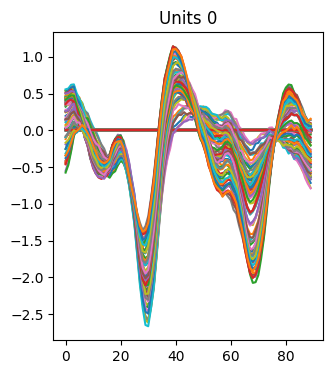

(22, 90, 192)


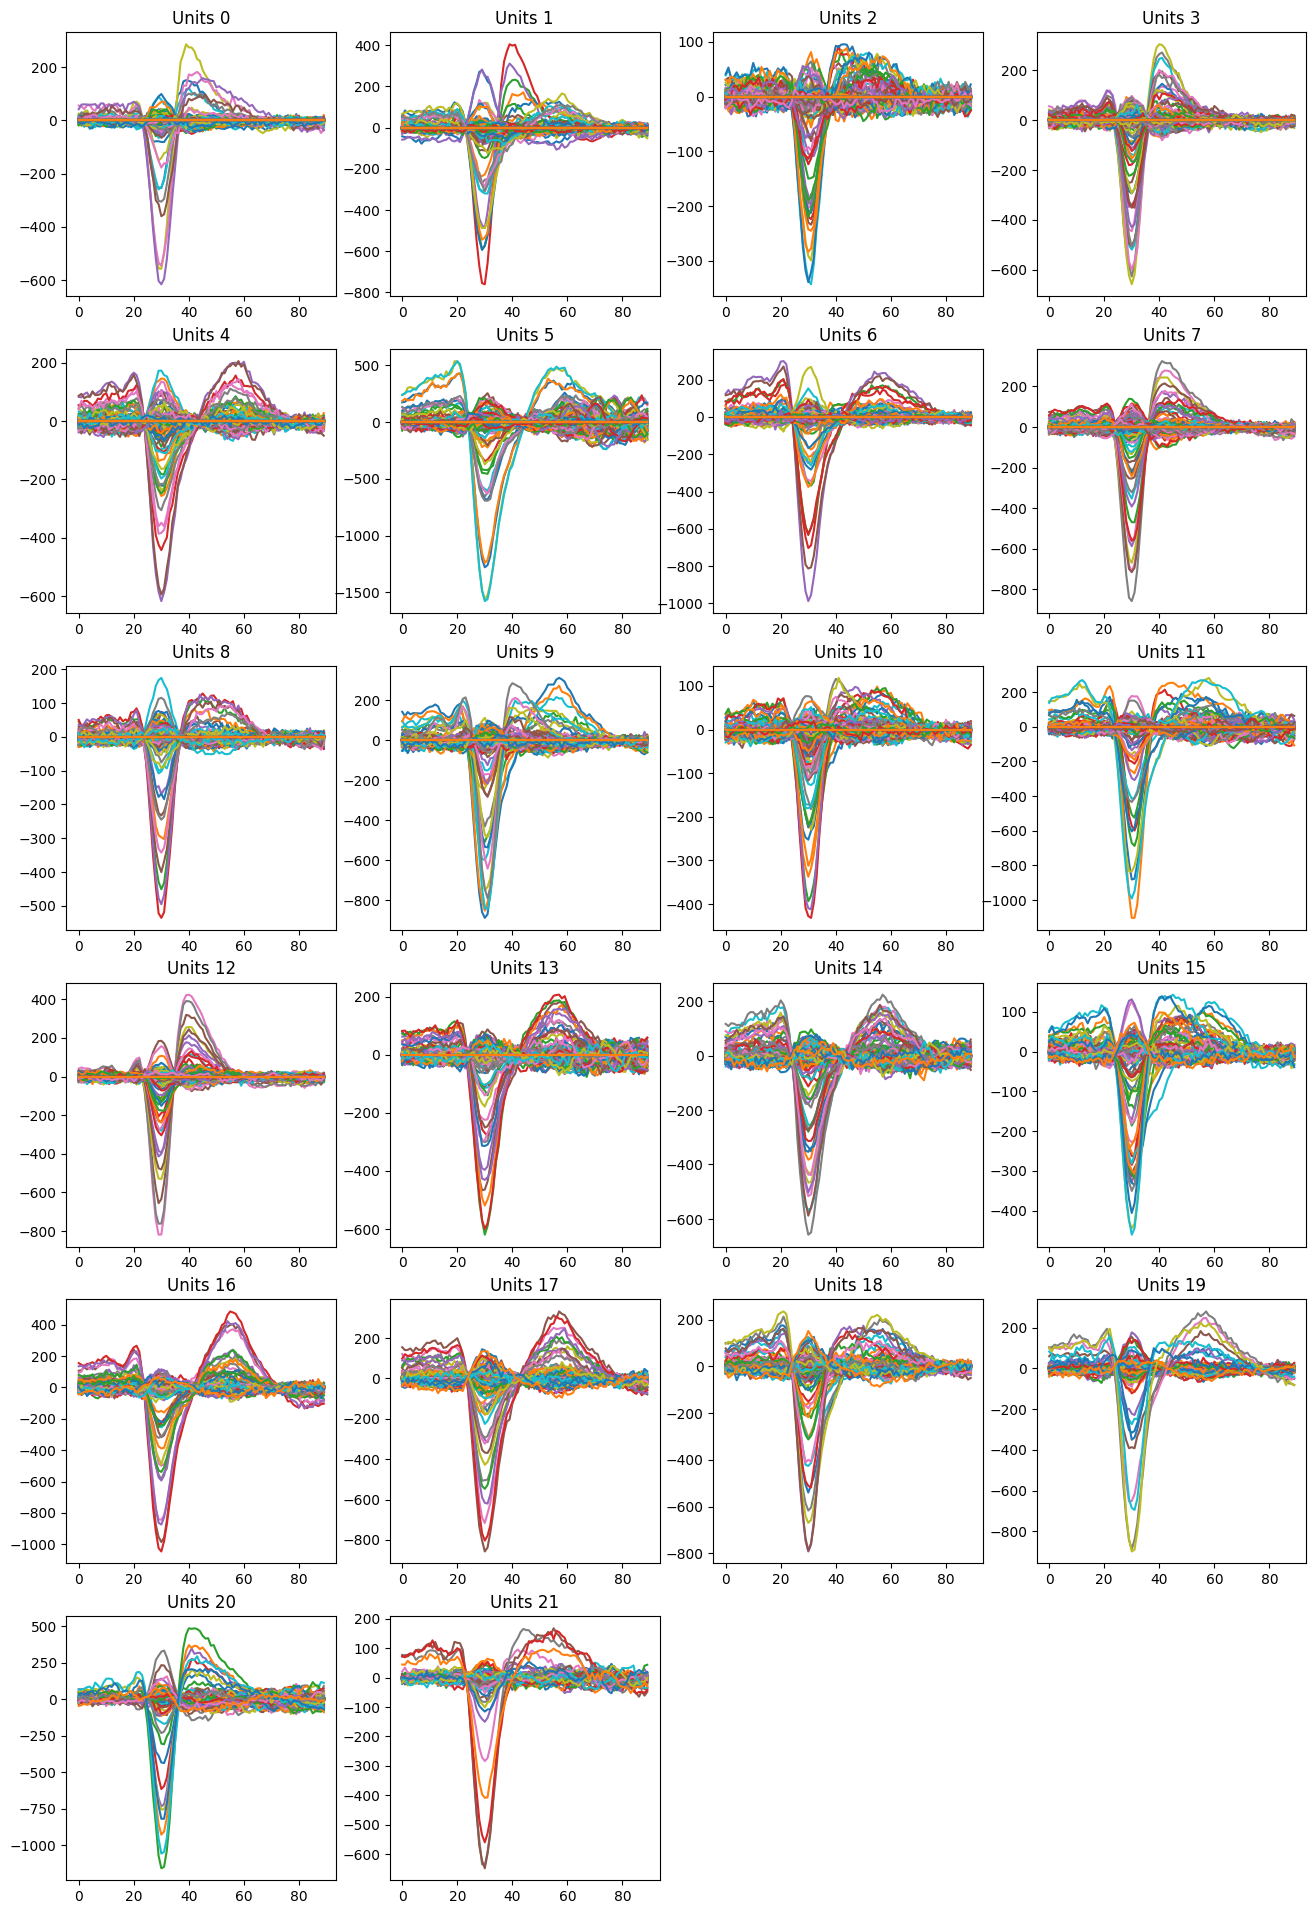

(107, 90, 192)


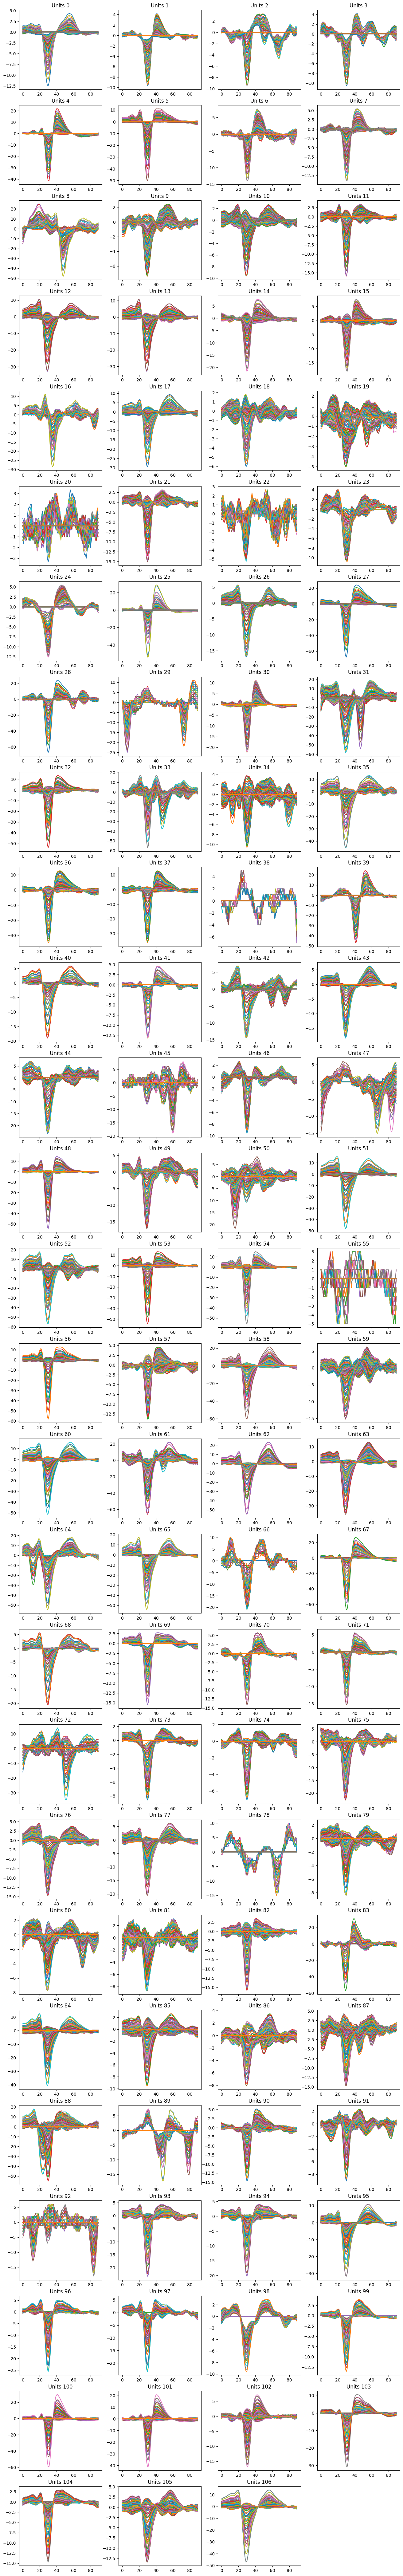

In [25]:
for i, analyzer in enumerate(analyzer_list):
    if analyzer is not None:
        templates = analyzer.get_extension("templates").get_data()
        print(templates.shape)
        n_templates = len(templates)
        n_rows = (n_templates + 3) // 4  # 4列で行数を計算
        fig, axes = plt.subplots(n_rows, 4, figsize=(4*4, 4*n_rows))
        
        # axesを1次元配列に変換
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        axes_flat = axes.flatten()
        
        for j, template in enumerate(templates):
            if j < len(axes_flat):
                axes_flat[j].plot(template)
                axes_flat[j].set_title(f"Units {j}")
                # axes_flat[j].set_xlabel("Time (samples)")
                # axes_flat[j].set_ylabel("Amplitude")
        
        # 使用しないサブプロットを非表示
        for j in range(len(templates), len(axes_flat)):
            axes_flat[j].set_visible(False)
    else:
        continue
    
    # plt.tight_layout()
    plt.show()


In [ ]:
for i, analyzer in enumerate(analyzer_list):
    # analyzer.compute("quality_metrics")
    if analyzer is not None:
        quality_metrics = analyzer.get_extension("quality_metrics")
        # print(quality_metrics["isi_violations_ratio"].shape)
        plt.plot(quality_metrics["isi_violations_ratio"])
        plt.show()
    else:
        continue
    
    

TypeError: 'NoneType' object is not subscriptable

: 

In [ ]:
def get_spike_num_by_unit(sorting, dtype="dict"):
    spike_num = {}
    for unit_id in sorting.get_unit_ids():
        spike_num[unit_id] = len(sorting.get_unit_spike_train(unit_id))
    if dtype == "dict":
        return spike_num
    elif dtype == "list":
        return list(spike_num.values())
    else:
        ValueError("dtype must be 'dict' or 'list'")

for i, sorting in enumerate(sorting_list):
    if sorting is not None:
        isi_violation_list = get_isi_violation_rate_by_unit(sorting, dtype="list")
        spike_num_list = get_spike_num_by_unit(sorting, dtype="list")
        plt.scatter(spike_num_list, isi_violation_list, label=sorters[i])
    else:
        continue
    plt.legend()
    plt.show()


In [ ]:
gt_analyzer = si.create_sorting_analyzer(sorting=gt_sorting, recording=recording)
gt_analyzer.compute(['random_spikes', 'waveforms', 'templates', 'noise_levels'])
_ = gt_analyzer.compute('spike_amplitudes')
_ = gt_analyzer.compute('principal_components', n_components = 5, mode="by_channel_local")
sexp.export_to_phy(sorting_analyzer=gt_analyzer, output_folder=f"{dir_path}/cars/phy", remove_if_exists=True)

for i, sorting in enumerate(sorting_list):
    if sorting is not None:
        analyzer = si.create_sorting_analyzer(sorting=sorting, recording=recording)
        analyzer.compute(['random_spikes', 'waveforms', 'templates', 'noise_levels'])
        _ = analyzer.compute('spike_amplitudes')
        _ = analyzer.compute('principal_components', n_components = 5, mode="by_channel_local")
        sexp.export_to_phy(sorting_analyzer=analyzer, output_folder=f"{dir_path}/{sorters[i]}/phy", remove_if_exists=True)

estimate_sparsity (workers: 4 processes): 100%|██████████| 10/10 [00:00<?, ?it/s]


create_sorting_analyzer: recording does not have scaling to uV, forcing return_in_uV=False


extract PCs (workers: 4 processes): 100%|██████████| 10/10 [00:02<00:00,  4.69it/s]


Run:
phy template-gui  C:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\ex20_condition2\cars\phy\params.py


In [ ]:
# sw.plot_all_amplitudes_distributions(analyzer_list[0])
# sw.plot_amplitudes(analyzer_list[0])
# sw.plot_autocorrelograms(analyzer_list[0])
# # sw.plot_comparison_collision_by_similarity(
# #     comp_gt_list[0], 
# #     templates_array=np.load(dir_path / "spike_templates.npy", allow_pickle=True).T,
# #     )
# sw.plot_crosscorrelograms(analyzer_list[0])
# sw.plot_isi_distribution(analyzer_list[0])


In [ ]:
# sw.plot_multicomparison_agreement(comp_gt_list[0])
# sw.plot_multicomparison_agreement_by_sorter(comp_gt_list[0])
# sw.plot_multicomparison_graph(comp_gt_list[0])
# sw.plot_peak_activity(recording, analyzer_list[0].get_detect_peaks())
# sw.plot_probe_map(recording)
# # sw.plot_quality_metrics(analyzer_list[0])
# sw.plot_rasters(analyzer_list[0])

# sw.plot_sorting_summary(analyzer_list[0], backend="spikeinterface_gui")